<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [22]</a>'.</span>

In [1]:
import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download
import lamindb as ln

from scprint.tasks import Embedder
from scprint.tasks.cell_emb import display_confusion_matrix
import pandas as pd

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from anndata import AnnData
from scdataloader.utils import translate
import bionty as bt
from scprint.tasks.cell_emb import compute_classification

from lightning.pytorch import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from scdataloader import SimpleAnnDataset, Collator, DataModule
from torch.utils.data import DataLoader

import lamindb as ln

%load_ext autoreload
%autoreload 2

import torch
import scipy.sparse

torch.set_float32_matmul_precision("medium")

→ connected lamindb: jkobject/scprint2


/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1044: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/pasteur/appa/homes/jkalfon/simpler_flash/src/simpler_flash/layer_norm.py:1107: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
# model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
# )
# model_checkpoint_file = ../data/
model_checkpoint_file = "../../../1lzuxvg0.ckpt"
# w937u4o1.ckpt'
# da6ao55o.ckpt # 649
# 1lzuxvg0.ckpt # 677

In [3]:
model = scPrint.load_from_checkpoint(
    model_checkpoint_file, precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


FYI: scPrint is not attached to a `Trainer`.


In [4]:
da = sc.read("./data/task_3_embed.h5ad")

In [5]:
map_to_val = {n: i for i, n in enumerate(set(da.obs["batch"].unique()))}
da.obs["batch"] = da.obs["batch"].map(map_to_val)

In [6]:
# Prepare data for fine-tuning (using the cat/tiger dataset from above)
# Split data into train/val
n_train = int(0.8 * len(da))
train_idx = np.random.choice(len(da), n_train, replace=False)
val_idx = np.setdiff1d(np.arange(len(da)), train_idx)

train_data = da[train_idx].copy()
val_data = da[val_idx].copy()

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

mencoders = {}
for k, v in model.label_decoders.items():
    mencoders[k] = {va: ke for ke, va in v.items()}
# this needs to remain its original name as it is expect like that by collator, otherwise need to send org_to_id as params
mencoders.pop("organism_ontology_term_id")

# Create datasets
train_dataset = SimpleAnnDataset(
    train_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

val_dataset = SimpleAnnDataset(
    val_data,
    obs_to_output=["cell_type_ontology_term_id", "batch", "organism_ontology_term_id"],
    get_knn_cells=model.expr_emb_style == "metacell",
    encoder=mencoders,
)

# Create collator
collator = Collator(
    organisms=model.organisms,
    valid_genes=model.genes,
    class_names=["cell_type_ontology_term_id", "batch"],
    how="random expr",  # or "all expr" for full expression
    max_len=2800,
    add_zero_genes=0,
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    collate_fn=collator,
    batch_size=32,  # Adjust based on GPU memory
    num_workers=4,
    shuffle=True,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    collate_fn=collator,
    batch_size=32,
    num_workers=4,
    shuffle=False,
    pin_memory=True,
)

Training data: (21760, 57066)
Validation data: (5440, 57066)


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


In [7]:
d_model_org = 8
batch_cls = torch.nn.Sequential(
    torch.nn.Linear(d_model_org, d_model_org * 8),
    torch.nn.ReLU(),
    torch.nn.Linear(d_model_org * 8, len(set(da.obs["batch"].unique()))),
)
batch_cls = batch_cls.to(model.device)

In [8]:
for val in model.parameters():
    val.requires_grad = False
    # setting all to TRUE

for val in model.cell_transformer.parameters():
    val.requires_grad = True
# for val in model.transformer.blocks[7].parameters():
#    val.requires_grad = True
for i in model.transformer.blocks:
    i.cross_attn.requires_grad = True
for val in model.compressor.parameters():
    val.requires_grad = True
for val in model.cls_decoders["cell_type_ontology_term_id"].parameters():
    val.requires_grad = True

In [9]:
def mmd_loss(X, Y):
    """
    Compute Maximum Mean Discrepancy (MMD) loss between two 2D embedding matrices.

    Args:
        X: Tensor of shape (n1, emb_dim) - first set of embeddings
        Y: Tensor of shape (n2, emb_dim) - second set of embeddings

    Returns:
        MMD loss value (negative to encourage dissimilarity)
    """

    def rbf_kernel(x, y, sigma):
        """Compute RBF kernel between two sets of vectors"""
        distance = torch.cdist(x, y, p=2) ** 2
        return torch.exp(-distance / (2 * sigma**2))

    # Use multiple kernel bandwidths for better performance
    sigmas = [0.1, 1.0, 10.0]
    mmd_loss = 0.0

    for sigma in sigmas:
        # K(X, X) - kernel matrix within first group (n1 x n1)
        k_xx = rbf_kernel(X, X, sigma)
        # K(Y, Y) - kernel matrix within second group (n2 x n2)
        k_yy = rbf_kernel(Y, Y, sigma)
        # K(X, Y) - kernel matrix between groups (n1 x n2)
        k_xy = rbf_kernel(X, Y, sigma)

        # Unbiased MMD estimation
        n1 = X.shape[0]
        n2 = Y.shape[0]

        # Remove diagonal elements for unbiased estimation of K(X,X) and K(Y,Y)
        # For K(X,X): exclude diagonal
        if n1 > 1:
            mask_xx = 1 - torch.eye(n1, device=X.device)
            k_xx_term = (k_xx * mask_xx).sum() / (n1 * (n1 - 1))
        else:
            k_xx_term = 0.0

        # For K(Y,Y): exclude diagonal
        if n2 > 1:
            mask_yy = 1 - torch.eye(n2, device=Y.device)
            k_yy_term = (k_yy * mask_yy).sum() / (n2 * (n2 - 1))
        else:
            k_yy_term = 0.0

        # For K(X,Y): use all elements (no diagonal to exclude)
        k_xy_term = k_xy.mean()

        # MMD^2 = E[K(X,X)] + E[K(Y,Y)] - 2*E[K(X,Y)]
        mmd_squared = k_xx_term + k_yy_term - 2 * k_xy_term
        mmd_loss += mmd_squared

    # Return negative MMD to encourage dissimilarity (higher MMD = more different)
    return mmd_loss / len(sigmas)

In [10]:
def batch_corr_pass(batch):
    gene_pos = batch["genes"].to(model.device)
    expression = batch["x"].to(model.device)
    depth = batch["depth"].to(model.device)
    class_elem = batch["class"].long().to(model.device)
    total_loss = 0

    # Forward pass with automatic mixed precisio^n
    with torch.cuda.amp.autocast():
        # Forward pass
        output = model.forward(
            gene_pos,
            expression,
            req_depth=depth,
            depth_mult=expression.sum(1),
            do_class=True,
            metacell_token=torch.zeros_like(depth),
        )
        ## adaptor on ct_emb
        # ctpos = model.classes.index("cell_type_ontology_term_id") + 1
        # emb = output["output_cell_embs"][:, ctpos, :]
        #
        # output["output_cell_embs"][:, ctpos, :] = adaptor_layer(
        #    torch.cat([emb, class_elem[:, 1].unsqueeze(1).float()], dim=1)
        # )

        ## generate expr loss
        output_gen = model._generate(
            cell_embs=output["output_cell_embs"],
            gene_pos=gene_pos,
            depth_mult=expression.sum(1),
            req_depth=depth,
        )
        if "zero_logits" in output_gen:
            loss_expr = loss.zinb(
                theta=output_gen["disp"],
                pi=output_gen["zero_logits"],
                mu=output_gen["mean"],
                target=expression,
            )
            if model.zinb_and_mse:
                loss_expr += (
                    loss.mse(
                        input=torch.log(output_gen["mean"] + 1)
                        * (1 - torch.sigmoid(output_gen["zero_logits"])),
                        target=torch.log(expression + 1),
                    )
                    / 10  # scale to make it more similar to the zinb
                )
        else:
            loss_expr = loss.mse(
                input=torch.log(output_gen["mean"] + 1),
                target=torch.log(expression + 1),
            )
        # Add expression loss to total
        total_loss += loss_expr

        # ct clss
        cls_output = output.get("cls_output_cell_type_ontology_term_id")
        # ct_output = output["output_cell_embs"][:, ctpos, :]
        # cls_output = model.cls_decoders["cell_type_ontology_term_id"](ct_output)
        cls_loss = loss.hierarchical_classification(
            pred=cls_output,
            cl=class_elem[:, 0],
            labels_hierarchy=model.mat_labels_hierarchy.get(
                "cell_type_ontology_term_id"
            ).to("cuda"),
        )

        # organ class
        org_emb = output["compressed_cell_embs"][
            model.classes.index("organism_ontology_term_id") + 1
        ]
        cls_loss += F.cross_entropy(
            input=batch_cls(org_emb),
            target=class_elem[:, 1],
        )
        total_loss += cls_loss * 10

        pos = model.classes.index("cell_type_ontology_term_id") + 1
        # Apply gradient reversal to the input embedding
        selected_emb = (
            output["compressed_cell_embs"][pos]
            if model.compressor is not None
            else output["input_cell_embs"][:, pos, :]
        )
        X, Y = selected_emb[class_elem[:, 1] == 1], selected_emb[class_elem[:, 1] == 0]
        mmd = mmd_loss(X, Y)
        mmd = mmd.item() if not torch.isnan(mmd) else 0

        # Add adversarial loss to total loss
        total_loss += mmd * 3
        total_loss += output["vae_kl_loss"] * 0.1
    return total_loss, cls_loss, mmd, loss_expr

In [11]:
# Alternative: Manual Training Loop (for more control)
# If you prefer to have more control over the training process
from tqdm import tqdm
import torch.nn.functional as F
from scprint.model import loss

num_epochs = 10
lr = 0.0002

# Setup optimizer
all_params = (
    list(model.parameters()) + list(batch_cls.parameters())
    # + list(batch_vector.parameters())
)
optimizer = torch.optim.AdamW(
    all_params, lr=lr, weight_decay=0.01, betas=(0.9, 0.999), eps=1e-8
)

# Setup scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.2, patience=1
)

# Setup automatic mixed precision
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

_ = model.train()

for k, i in model.mat_labels_hierarchy.items():
    model.mat_labels_hierarchy[k] = i.to(model.device)

/local/scratch/tmp/ipykernel_3412904/1591752259.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None


In [12]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']:.2e}")

    # Training phase
    train_loss = 0.0
    train_steps = 0
    avg_adv = 0
    avg_expr = 0
    avg_cls = 0
    avg_mmd = 0

    # pbar = tqdm(train_loader, desc="Training")
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()
        total_loss, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
        # Backward pass
        scaler.scale(total_loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += total_loss.item()
        train_steps += 1
        avg_cls += cls_loss.item()
        avg_expr += loss_expr.item()
        avg_mmd += mmd
        # Update progress bar
        # if batch_idx % 35 == 0:
        # print(
        #    f"avg_loss {train_loss / train_steps:.4f}, avg_cls {avg_cls / train_steps:.4f}, avg_expr {avg_expr / train_steps:.4f}, avg_adv {avg_mmd/ train_steps:.4f}"
        # )
        # pbar.set_postfix(
        #    {
        #        "loss": f"{total_loss.item():.4f}",
        #        "avg_loss": f"{train_loss / train_steps:.4f}",
        #        "cls_loss": f"{cls_loss.item():.4f}",
        #        "mmd_loss": f"{mmd:.4f}",
        #        "expr_loss": f"{loss_expr.item():.4f}",
        #    }
        # )

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_loss_expr = 0.0
    val_mmd = 0.0
    val_cls = 0.0
    val_loss_to_prt = 0.0

    with torch.no_grad():
        for batch in val_loader:  # tqdm(val_loader, desc="Validation"):
            loss_val, cls_loss, mmd, loss_expr = batch_corr_pass(batch)
            val_loss_to_prt += loss_val.item()
            val_loss += loss_val.item()
            val_steps += 1
            val_loss_expr += loss_expr.item()
            val_mmd += mmd
            val_cls += cls_loss.item()
    try:
        avg_val_loss = val_loss_to_prt / val_steps
        avg_train_loss = train_loss / train_steps
    except ZeroDivisionError:
        print("Error: Division by zero occurred while calculating average losses.")
        avg_train_loss = 0
    print(
        "cls_loss: {:.4f}, mmd_loss: {:.4f}, expr_loss: {:.4f}".format(
            val_cls / val_steps, val_mmd / val_steps, val_loss_expr / val_steps
        )
    )
    print(f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Store LR before scheduler step for comparison
    lr_before = optimizer.param_groups[0]["lr"]

    # Update learning rate
    scheduler.step(avg_val_loss)

    # Check if LR was reduced
    lr_after = optimizer.param_groups[0]["lr"]
    if lr_after < lr_before:
        print(
            f"🔻 Learning rate reduced from {lr_before:.2e} to {lr_after:.2e} (factor: {lr_after / lr_before:.3f})"
        )
    else:
        print(f"✅ Learning rate unchanged: {lr_after:.2e}")

    # Early stopping check (simple implementation)
    if epoch > 3 and val_loss / val_steps > 1.3 * avg_train_loss:
        print("Early stopping due to overfitting")
        break

print("Manual fine-tuning completed!")


Epoch 1/10
Current learning rate: 2.00e-04


/local/scratch/tmp/ipykernel_3412904/1796114099.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


cls_loss: 0.0342, mmd_loss: 0.0007, expr_loss: 1.0413
Train Loss: 3.7526, Val Loss: 1.3850
✅ Learning rate unchanged: 2.00e-04

Epoch 2/10
Current learning rate: 2.00e-04


cls_loss: 0.0095, mmd_loss: 0.0006, expr_loss: 1.0374
Train Loss: 1.5688, Val Loss: 1.1341
✅ Learning rate unchanged: 2.00e-04

Epoch 3/10
Current learning rate: 2.00e-04


cls_loss: 0.0064, mmd_loss: 0.0005, expr_loss: 1.0359
Train Loss: 1.4428, Val Loss: 1.1012
✅ Learning rate unchanged: 2.00e-04

Epoch 4/10
Current learning rate: 2.00e-04


cls_loss: 0.0060, mmd_loss: 0.0005, expr_loss: 1.0344
Train Loss: 1.3993, Val Loss: 1.0956
✅ Learning rate unchanged: 2.00e-04

Epoch 5/10
Current learning rate: 2.00e-04


cls_loss: 0.0058, mmd_loss: 0.0004, expr_loss: 1.0359
Train Loss: 1.3877, Val Loss: 1.0952
✅ Learning rate unchanged: 2.00e-04

Epoch 6/10
Current learning rate: 2.00e-04


cls_loss: 0.0096, mmd_loss: 0.0005, expr_loss: 1.0371
Train Loss: 1.3687, Val Loss: 1.1352
✅ Learning rate unchanged: 2.00e-04

Epoch 7/10
Current learning rate: 2.00e-04


cls_loss: 0.0084, mmd_loss: 0.0004, expr_loss: 1.0369
Train Loss: 1.3635, Val Loss: 1.1224
🔻 Learning rate reduced from 2.00e-04 to 4.00e-05 (factor: 0.200)

Epoch 8/10
Current learning rate: 4.00e-05


cls_loss: 0.0053, mmd_loss: 0.0004, expr_loss: 1.0368
Train Loss: 1.3553, Val Loss: 1.0910
✅ Learning rate unchanged: 4.00e-05

Epoch 9/10
Current learning rate: 4.00e-05


cls_loss: 0.0077, mmd_loss: 0.0004, expr_loss: 1.0358
Train Loss: 1.3315, Val Loss: 1.1143
✅ Learning rate unchanged: 4.00e-05

Epoch 10/10
Current learning rate: 4.00e-05


cls_loss: 0.0055, mmd_loss: 0.0004, expr_loss: 1.0354
Train Loss: 1.3242, Val Loss: 1.0921
🔻 Learning rate reduced from 4.00e-05 to 8.00e-06 (factor: 0.200)
Manual fine-tuning completed!


In [13]:
import lightning as L

checkpoint = {
    "epoch": epoch,
    "global_step": (1 + epoch) * batch_idx,
    "pytorch-lightning_version": L.__version__,
    "state_dict": model.state_dict(),
    "optimizer_states": [optimizer.state_dict()],
    "lr_schedulers": [scheduler.state_dict()],
    "hparams_name": None,
    "loops": None,
    "callbacks": None,
    "hyper_parameters": model.hparams,
}
torch.save(checkpoint, "fit_2.ckpt")

In [14]:
# model.load_state_dict(torch.load("fit_2.ckpt")["state_dict"])

In [15]:
model = scPrint.load_from_checkpoint(
    "fit_2.ckpt", precpt_gene_emb=None, attention="normal"
)
model = model.to("cuda")

Gene position encoding has changed in the dataloader compared to last time, trying to revert


/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


FYI: scPrint is not attached to a `Trainer`.


In [16]:
#da.obs = da.obs.iloc[:, :-15]
#for i in [
#    "scprint_emb",
#    "scprint_emb_age_group",
#    "scprint_emb_assay_ontology_term_id",
#    "scprint_emb_cell_culture",
#    "scprint_emb_cell_type_ontology_term_id",
#    "scprint_emb_disease_ontology_term_id",
#    "scprint_emb_organism_ontology_term_id",
#    "scprint_emb_other",
#    "scprint_emb_self_reported_ethnicity_ontology_term_id",
#    "scprint_emb_sex_ontology_term_id",
#    "scprint_emb_tissue_ontology_term_id",
#]:
#    da.obsm.pop(i)

In [17]:
embed = Embedder(
    how="random expr",
    max_len=2800,
    num_workers=8,
    pred_embedding=["all"],
    doplot=False,
)

In [18]:
n_adata, metrics = embed(model, da.copy())

/pasteur/appa/homes/jkalfon/scdataloader/scdataloader/utils.py:427: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  organismdf = pd.concat(organismdf)


not on wandb, could not set name



  0%|          | 0/425 [00:00<?, ?it/s]


  0%|          | 1/425 [00:04<29:13,  4.14s/it]


  0%|          | 2/425 [00:04<12:41,  1.80s/it]


  1%|          | 3/425 [00:04<07:22,  1.05s/it]


  1%|          | 4/425 [00:04<04:52,  1.44it/s]


  1%|          | 5/425 [00:04<03:29,  2.00it/s]


  1%|▏         | 6/425 [00:04<02:40,  2.61it/s]


  2%|▏         | 7/425 [00:05<02:08,  3.25it/s]


  2%|▏         | 8/425 [00:05<01:47,  3.87it/s]


  2%|▏         | 9/425 [00:05<01:34,  4.39it/s]


  2%|▏         | 10/425 [00:05<01:25,  4.87it/s]


  3%|▎         | 11/425 [00:05<01:18,  5.27it/s]


  3%|▎         | 12/425 [00:05<01:13,  5.59it/s]


  3%|▎         | 13/425 [00:05<01:10,  5.85it/s]


  3%|▎         | 14/425 [00:06<01:08,  6.02it/s]


  4%|▎         | 15/425 [00:06<01:06,  6.17it/s]


  4%|▍         | 16/425 [00:06<01:05,  6.28it/s]


  4%|▍         | 17/425 [00:06<01:04,  6.33it/s]


  4%|▍         | 18/425 [00:06<01:03,  6.36it/s]


  4%|▍         | 19/425 [00:06<01:03,  6.41it/s]


  5%|▍         | 20/425 [00:07<01:02,  6.43it/s]


  5%|▍         | 21/425 [00:07<01:02,  6.44it/s]


  5%|▌         | 22/425 [00:07<01:02,  6.45it/s]


  5%|▌         | 23/425 [00:07<01:02,  6.46it/s]


  6%|▌         | 24/425 [00:07<01:01,  6.47it/s]


  6%|▌         | 25/425 [00:07<01:01,  6.48it/s]


  6%|▌         | 26/425 [00:08<01:01,  6.49it/s]


  6%|▋         | 27/425 [00:08<01:01,  6.49it/s]


  7%|▋         | 28/425 [00:08<01:00,  6.51it/s]


  7%|▋         | 29/425 [00:08<01:01,  6.48it/s]


  7%|▋         | 30/425 [00:08<01:00,  6.49it/s]


  7%|▋         | 31/425 [00:08<01:00,  6.48it/s]


  8%|▊         | 32/425 [00:08<01:00,  6.49it/s]


  8%|▊         | 33/425 [00:09<01:00,  6.48it/s]


  8%|▊         | 34/425 [00:09<01:00,  6.49it/s]


  8%|▊         | 35/425 [00:09<01:00,  6.49it/s]


  8%|▊         | 36/425 [00:09<00:59,  6.50it/s]


  9%|▊         | 37/425 [00:09<00:59,  6.48it/s]


  9%|▉         | 38/425 [00:09<00:59,  6.48it/s]


  9%|▉         | 39/425 [00:10<01:00,  6.43it/s]


  9%|▉         | 40/425 [00:10<00:59,  6.43it/s]


 10%|▉         | 41/425 [00:10<00:59,  6.45it/s]


 10%|▉         | 42/425 [00:10<00:59,  6.44it/s]


 10%|█         | 43/425 [00:10<00:59,  6.46it/s]


 10%|█         | 44/425 [00:10<00:58,  6.47it/s]


 11%|█         | 45/425 [00:10<00:58,  6.47it/s]


 11%|█         | 46/425 [00:11<00:58,  6.47it/s]


 11%|█         | 47/425 [00:11<00:58,  6.48it/s]


 11%|█▏        | 48/425 [00:11<00:57,  6.51it/s]


 12%|█▏        | 49/425 [00:11<00:57,  6.50it/s]


 12%|█▏        | 50/425 [00:11<00:57,  6.51it/s]


 12%|█▏        | 51/425 [00:11<00:57,  6.48it/s]


 12%|█▏        | 52/425 [00:12<00:57,  6.47it/s]


 12%|█▏        | 53/425 [00:12<00:57,  6.47it/s]


 13%|█▎        | 54/425 [00:12<00:57,  6.44it/s]


 13%|█▎        | 55/425 [00:12<00:57,  6.47it/s]


 13%|█▎        | 56/425 [00:12<00:57,  6.47it/s]


 13%|█▎        | 57/425 [00:12<00:56,  6.50it/s]


 14%|█▎        | 58/425 [00:12<00:56,  6.48it/s]


 14%|█▍        | 59/425 [00:13<00:58,  6.30it/s]


 14%|█▍        | 60/425 [00:13<00:57,  6.37it/s]


 14%|█▍        | 61/425 [00:13<00:56,  6.40it/s]


 15%|█▍        | 62/425 [00:13<00:56,  6.43it/s]


 15%|█▍        | 63/425 [00:13<00:56,  6.43it/s]


 15%|█▌        | 64/425 [00:13<00:56,  6.43it/s]


 15%|█▌        | 65/425 [00:14<00:56,  6.40it/s]


 16%|█▌        | 66/425 [00:14<00:56,  6.41it/s]


 16%|█▌        | 67/425 [00:14<00:56,  6.38it/s]


 16%|█▌        | 68/425 [00:14<00:55,  6.38it/s]


 16%|█▌        | 69/425 [00:14<00:55,  6.40it/s]


 16%|█▋        | 70/425 [00:14<00:55,  6.37it/s]


 17%|█▋        | 71/425 [00:14<00:55,  6.37it/s]


 17%|█▋        | 72/425 [00:15<00:55,  6.35it/s]


 17%|█▋        | 73/425 [00:15<00:55,  6.33it/s]


 17%|█▋        | 74/425 [00:15<00:55,  6.33it/s]


 18%|█▊        | 75/425 [00:15<00:56,  6.20it/s]


 18%|█▊        | 76/425 [00:15<00:55,  6.24it/s]


 18%|█▊        | 77/425 [00:15<00:55,  6.28it/s]


 18%|█▊        | 78/425 [00:16<00:54,  6.35it/s]


 19%|█▊        | 79/425 [00:16<00:54,  6.34it/s]


 19%|█▉        | 80/425 [00:16<00:54,  6.39it/s]


 19%|█▉        | 81/425 [00:16<00:53,  6.40it/s]


 19%|█▉        | 82/425 [00:16<00:53,  6.43it/s]


 20%|█▉        | 83/425 [00:16<00:53,  6.44it/s]


 20%|█▉        | 84/425 [00:17<00:52,  6.49it/s]


 20%|██        | 85/425 [00:17<00:52,  6.46it/s]


 20%|██        | 86/425 [00:17<00:52,  6.44it/s]


 20%|██        | 87/425 [00:17<00:52,  6.41it/s]


 21%|██        | 88/425 [00:17<00:52,  6.43it/s]


 21%|██        | 89/425 [00:17<00:52,  6.43it/s]


 21%|██        | 90/425 [00:17<00:52,  6.43it/s]


 21%|██▏       | 91/425 [00:18<00:52,  6.39it/s]


 22%|██▏       | 92/425 [00:18<00:51,  6.41it/s]


 22%|██▏       | 93/425 [00:18<00:51,  6.39it/s]


 22%|██▏       | 94/425 [00:18<00:51,  6.39it/s]


 22%|██▏       | 95/425 [00:18<00:51,  6.38it/s]


 23%|██▎       | 96/425 [00:18<00:51,  6.39it/s]


 23%|██▎       | 97/425 [00:19<00:51,  6.39it/s]


 23%|██▎       | 98/425 [00:19<00:51,  6.40it/s]


 23%|██▎       | 99/425 [00:19<00:50,  6.39it/s]


 24%|██▎       | 100/425 [00:19<00:50,  6.40it/s]


 24%|██▍       | 101/425 [00:19<00:50,  6.40it/s]


 24%|██▍       | 102/425 [00:19<00:50,  6.42it/s]


 24%|██▍       | 103/425 [00:19<00:50,  6.42it/s]


 24%|██▍       | 104/425 [00:20<00:50,  6.42it/s]


 25%|██▍       | 105/425 [00:20<00:49,  6.43it/s]


 25%|██▍       | 106/425 [00:20<00:49,  6.42it/s]


 25%|██▌       | 107/425 [00:20<00:49,  6.41it/s]


 25%|██▌       | 108/425 [00:20<00:49,  6.41it/s]


 26%|██▌       | 109/425 [00:20<00:49,  6.40it/s]


 26%|██▌       | 110/425 [00:21<00:49,  6.38it/s]


 26%|██▌       | 111/425 [00:21<00:49,  6.36it/s]


 26%|██▋       | 112/425 [00:21<00:49,  6.38it/s]


 27%|██▋       | 113/425 [00:21<00:48,  6.40it/s]


 27%|██▋       | 114/425 [00:21<00:48,  6.40it/s]


 27%|██▋       | 115/425 [00:21<00:48,  6.39it/s]


 27%|██▋       | 116/425 [00:22<00:48,  6.40it/s]


 28%|██▊       | 117/425 [00:22<00:48,  6.41it/s]


 28%|██▊       | 118/425 [00:22<00:47,  6.41it/s]


 28%|██▊       | 119/425 [00:22<00:47,  6.38it/s]


 28%|██▊       | 120/425 [00:22<00:47,  6.38it/s]


 28%|██▊       | 121/425 [00:22<00:47,  6.42it/s]


 29%|██▊       | 122/425 [00:22<00:47,  6.42it/s]


 29%|██▉       | 123/425 [00:23<00:47,  6.42it/s]


 29%|██▉       | 124/425 [00:23<00:46,  6.43it/s]


 29%|██▉       | 125/425 [00:23<00:46,  6.43it/s]


 30%|██▉       | 126/425 [00:23<00:46,  6.43it/s]


 30%|██▉       | 127/425 [00:23<00:46,  6.38it/s]


 30%|███       | 128/425 [00:23<00:46,  6.37it/s]


 30%|███       | 129/425 [00:24<00:46,  6.40it/s]


 31%|███       | 130/425 [00:24<00:46,  6.39it/s]


 31%|███       | 131/425 [00:24<00:45,  6.39it/s]


 31%|███       | 132/425 [00:24<00:45,  6.41it/s]


 31%|███▏      | 133/425 [00:24<00:45,  6.43it/s]


 32%|███▏      | 134/425 [00:24<00:45,  6.37it/s]


 32%|███▏      | 135/425 [00:24<00:45,  6.36it/s]


 32%|███▏      | 136/425 [00:25<00:45,  6.36it/s]


 32%|███▏      | 137/425 [00:25<00:45,  6.37it/s]


 32%|███▏      | 138/425 [00:25<00:44,  6.39it/s]


 33%|███▎      | 139/425 [00:25<00:44,  6.38it/s]


 33%|███▎      | 140/425 [00:25<00:44,  6.40it/s]


 33%|███▎      | 141/425 [00:25<00:44,  6.40it/s]


 33%|███▎      | 142/425 [00:26<00:44,  6.40it/s]


 34%|███▎      | 143/425 [00:26<00:44,  6.35it/s]


 34%|███▍      | 144/425 [00:26<00:44,  6.38it/s]


 34%|███▍      | 145/425 [00:26<00:44,  6.35it/s]


 34%|███▍      | 146/425 [00:26<00:43,  6.39it/s]


 35%|███▍      | 147/425 [00:26<00:43,  6.35it/s]


 35%|███▍      | 148/425 [00:27<00:43,  6.38it/s]


 35%|███▌      | 149/425 [00:27<00:43,  6.33it/s]


 35%|███▌      | 150/425 [00:27<00:43,  6.38it/s]


 36%|███▌      | 151/425 [00:27<00:43,  6.34it/s]


 36%|███▌      | 152/425 [00:27<00:42,  6.37it/s]


 36%|███▌      | 153/425 [00:27<00:42,  6.36it/s]


 36%|███▌      | 154/425 [00:27<00:42,  6.37it/s]


 36%|███▋      | 155/425 [00:28<00:42,  6.41it/s]


 37%|███▋      | 156/425 [00:28<00:42,  6.38it/s]


 37%|███▋      | 157/425 [00:28<00:43,  6.13it/s]


 37%|███▋      | 158/425 [00:28<00:43,  6.16it/s]


 37%|███▋      | 159/425 [00:28<00:42,  6.26it/s]


 38%|███▊      | 160/425 [00:28<00:42,  6.26it/s]


 38%|███▊      | 161/425 [00:29<00:41,  6.34it/s]


 38%|███▊      | 162/425 [00:29<00:41,  6.33it/s]


 38%|███▊      | 163/425 [00:29<00:41,  6.38it/s]


 39%|███▊      | 164/425 [00:29<00:41,  6.36it/s]


 39%|███▉      | 165/425 [00:29<00:41,  6.34it/s]


 39%|███▉      | 166/425 [00:29<00:40,  6.33it/s]


 39%|███▉      | 167/425 [00:30<00:40,  6.32it/s]


 40%|███▉      | 168/425 [00:30<00:40,  6.30it/s]


 40%|███▉      | 169/425 [00:30<00:40,  6.33it/s]


 40%|████      | 170/425 [00:30<00:40,  6.31it/s]


 40%|████      | 171/425 [00:30<00:40,  6.29it/s]


 40%|████      | 172/425 [00:30<00:40,  6.31it/s]


 41%|████      | 173/425 [00:30<00:40,  6.29it/s]


 41%|████      | 174/425 [00:31<00:39,  6.29it/s]


 41%|████      | 175/425 [00:31<00:39,  6.30it/s]


 41%|████▏     | 176/425 [00:31<00:39,  6.32it/s]


 42%|████▏     | 177/425 [00:31<00:39,  6.35it/s]


 42%|████▏     | 178/425 [00:31<00:39,  6.33it/s]


 42%|████▏     | 179/425 [00:31<00:38,  6.36it/s]


 42%|████▏     | 180/425 [00:32<00:38,  6.30it/s]


 43%|████▎     | 181/425 [00:32<00:38,  6.31it/s]


 43%|████▎     | 182/425 [00:32<00:38,  6.32it/s]


 43%|████▎     | 183/425 [00:32<00:38,  6.32it/s]


 43%|████▎     | 184/425 [00:32<00:38,  6.34it/s]


 44%|████▎     | 185/425 [00:32<00:37,  6.33it/s]


 44%|████▍     | 186/425 [00:33<00:37,  6.32it/s]


 44%|████▍     | 187/425 [00:33<00:37,  6.34it/s]


 44%|████▍     | 188/425 [00:33<00:37,  6.33it/s]


 44%|████▍     | 189/425 [00:33<00:37,  6.34it/s]


 45%|████▍     | 190/425 [00:33<00:37,  6.32it/s]


 45%|████▍     | 191/425 [00:33<00:37,  6.30it/s]


 45%|████▌     | 192/425 [00:34<00:36,  6.31it/s]


 45%|████▌     | 193/425 [00:34<00:36,  6.32it/s]


 46%|████▌     | 194/425 [00:34<00:36,  6.32it/s]


 46%|████▌     | 195/425 [00:34<00:36,  6.32it/s]


 46%|████▌     | 196/425 [00:34<00:36,  6.33it/s]


 46%|████▋     | 197/425 [00:34<00:36,  6.31it/s]


 47%|████▋     | 198/425 [00:34<00:36,  6.30it/s]


 47%|████▋     | 199/425 [00:35<00:35,  6.32it/s]


 47%|████▋     | 200/425 [00:35<00:35,  6.33it/s]


 47%|████▋     | 201/425 [00:35<00:35,  6.32it/s]


 48%|████▊     | 202/425 [00:35<00:35,  6.32it/s]


 48%|████▊     | 203/425 [00:35<00:35,  6.30it/s]


 48%|████▊     | 204/425 [00:35<00:34,  6.32it/s]


 48%|████▊     | 205/425 [00:36<00:34,  6.31it/s]


 48%|████▊     | 206/425 [00:36<00:34,  6.32it/s]


 49%|████▊     | 207/425 [00:36<00:34,  6.30it/s]


 49%|████▉     | 208/425 [00:36<00:34,  6.28it/s]


 49%|████▉     | 209/425 [00:36<00:34,  6.26it/s]


 49%|████▉     | 210/425 [00:36<00:34,  6.27it/s]


 50%|████▉     | 211/425 [00:37<00:34,  6.29it/s]


 50%|████▉     | 212/425 [00:37<00:34,  6.17it/s]


 50%|█████     | 213/425 [00:37<00:34,  6.22it/s]


 50%|█████     | 214/425 [00:37<00:33,  6.22it/s]


 51%|█████     | 215/425 [00:37<00:35,  5.91it/s]


 51%|█████     | 216/425 [00:37<00:34,  6.00it/s]


 51%|█████     | 217/425 [00:38<00:34,  6.10it/s]


 51%|█████▏    | 218/425 [00:38<00:33,  6.16it/s]


 52%|█████▏    | 219/425 [00:38<00:33,  6.20it/s]


 52%|█████▏    | 220/425 [00:38<00:32,  6.25it/s]


 52%|█████▏    | 221/425 [00:38<00:32,  6.27it/s]


 52%|█████▏    | 222/425 [00:38<00:32,  6.28it/s]


 52%|█████▏    | 223/425 [00:38<00:32,  6.27it/s]


 53%|█████▎    | 224/425 [00:39<00:31,  6.29it/s]


 53%|█████▎    | 225/425 [00:39<00:33,  6.01it/s]


 53%|█████▎    | 226/425 [00:39<00:32,  6.11it/s]


 53%|█████▎    | 227/425 [00:39<00:32,  6.17it/s]


 54%|█████▎    | 228/425 [00:39<00:31,  6.21it/s]


 54%|█████▍    | 229/425 [00:39<00:31,  6.22it/s]


 54%|█████▍    | 230/425 [00:40<00:31,  6.28it/s]


 54%|█████▍    | 231/425 [00:40<00:30,  6.27it/s]


 55%|█████▍    | 232/425 [00:40<00:30,  6.29it/s]


 55%|█████▍    | 233/425 [00:40<00:30,  6.30it/s]


 55%|█████▌    | 234/425 [00:40<00:30,  6.30it/s]


 55%|█████▌    | 235/425 [00:40<00:30,  6.31it/s]


 56%|█████▌    | 236/425 [00:41<00:29,  6.30it/s]


 56%|█████▌    | 237/425 [00:41<00:29,  6.30it/s]


 56%|█████▌    | 238/425 [00:41<00:29,  6.30it/s]


 56%|█████▌    | 239/425 [00:41<00:29,  6.30it/s]


 56%|█████▋    | 240/425 [00:41<00:29,  6.30it/s]


 57%|█████▋    | 241/425 [00:41<00:29,  6.32it/s]


 57%|█████▋    | 242/425 [00:41<00:28,  6.31it/s]


 57%|█████▋    | 243/425 [00:42<00:28,  6.36it/s]


 57%|█████▋    | 244/425 [00:42<00:28,  6.34it/s]


 58%|█████▊    | 245/425 [00:42<00:28,  6.34it/s]


 58%|█████▊    | 246/425 [00:42<00:28,  6.31it/s]


 58%|█████▊    | 247/425 [00:42<00:28,  6.29it/s]


 58%|█████▊    | 248/425 [00:42<00:28,  6.28it/s]


 59%|█████▊    | 249/425 [00:43<00:28,  6.28it/s]


 59%|█████▉    | 250/425 [00:43<00:27,  6.26it/s]


 59%|█████▉    | 251/425 [00:43<00:27,  6.28it/s]


 59%|█████▉    | 252/425 [00:43<00:27,  6.26it/s]


 60%|█████▉    | 253/425 [00:43<00:27,  6.27it/s]


 60%|█████▉    | 254/425 [00:43<00:27,  6.28it/s]


 60%|██████    | 255/425 [00:44<00:26,  6.32it/s]


 60%|██████    | 256/425 [00:44<00:27,  6.25it/s]


 60%|██████    | 257/425 [00:44<00:26,  6.27it/s]


 61%|██████    | 258/425 [00:44<00:26,  6.29it/s]


 61%|██████    | 259/425 [00:44<00:26,  6.33it/s]


 61%|██████    | 260/425 [00:44<00:26,  6.32it/s]


 61%|██████▏   | 261/425 [00:45<00:25,  6.34it/s]


 62%|██████▏   | 262/425 [00:45<00:25,  6.31it/s]


 62%|██████▏   | 263/425 [00:45<00:25,  6.31it/s]


 62%|██████▏   | 264/425 [00:45<00:25,  6.33it/s]


 62%|██████▏   | 265/425 [00:45<00:25,  6.33it/s]


 63%|██████▎   | 266/425 [00:45<00:25,  6.31it/s]


 63%|██████▎   | 267/425 [00:45<00:25,  6.30it/s]


 63%|██████▎   | 268/425 [00:46<00:24,  6.29it/s]


 63%|██████▎   | 269/425 [00:46<00:24,  6.28it/s]


 64%|██████▎   | 270/425 [00:46<00:24,  6.28it/s]


 64%|██████▍   | 271/425 [00:46<00:24,  6.27it/s]


 64%|██████▍   | 272/425 [00:46<00:24,  6.25it/s]


 64%|██████▍   | 273/425 [00:46<00:24,  6.28it/s]


 64%|██████▍   | 274/425 [00:47<00:23,  6.30it/s]


 65%|██████▍   | 275/425 [00:47<00:23,  6.30it/s]


 65%|██████▍   | 276/425 [00:47<00:23,  6.29it/s]


 65%|██████▌   | 277/425 [00:47<00:23,  6.29it/s]


 65%|██████▌   | 278/425 [00:47<00:23,  6.28it/s]


 66%|██████▌   | 279/425 [00:47<00:23,  6.28it/s]


 66%|██████▌   | 280/425 [00:48<00:23,  6.26it/s]


 66%|██████▌   | 281/425 [00:48<00:22,  6.28it/s]


 66%|██████▋   | 282/425 [00:48<00:22,  6.29it/s]


 67%|██████▋   | 283/425 [00:48<00:22,  6.28it/s]


 67%|██████▋   | 284/425 [00:48<00:22,  6.24it/s]


 67%|██████▋   | 285/425 [00:48<00:22,  6.25it/s]


 67%|██████▋   | 286/425 [00:48<00:22,  6.28it/s]


 68%|██████▊   | 287/425 [00:49<00:21,  6.29it/s]


 68%|██████▊   | 288/425 [00:49<00:21,  6.28it/s]


 68%|██████▊   | 289/425 [00:49<00:21,  6.27it/s]


 68%|██████▊   | 290/425 [00:49<00:21,  6.24it/s]


 68%|██████▊   | 291/425 [00:49<00:21,  6.26it/s]


 69%|██████▊   | 292/425 [00:49<00:21,  6.28it/s]


 69%|██████▉   | 293/425 [00:50<00:21,  6.28it/s]


 69%|██████▉   | 294/425 [00:50<00:21,  6.22it/s]


 69%|██████▉   | 295/425 [00:50<00:20,  6.25it/s]


 70%|██████▉   | 296/425 [00:50<00:20,  6.28it/s]


 70%|██████▉   | 297/425 [00:50<00:20,  6.30it/s]


 70%|███████   | 298/425 [00:50<00:20,  6.28it/s]


 70%|███████   | 299/425 [00:51<00:20,  6.27it/s]


 71%|███████   | 300/425 [00:51<00:19,  6.28it/s]


 71%|███████   | 301/425 [00:51<00:19,  6.28it/s]


 71%|███████   | 302/425 [00:51<00:19,  6.28it/s]


 71%|███████▏  | 303/425 [00:51<00:19,  6.26it/s]


 72%|███████▏  | 304/425 [00:51<00:19,  6.26it/s]


 72%|███████▏  | 305/425 [00:52<00:19,  6.27it/s]


 72%|███████▏  | 306/425 [00:52<00:18,  6.27it/s]


 72%|███████▏  | 307/425 [00:52<00:18,  6.26it/s]


 72%|███████▏  | 308/425 [00:52<00:18,  6.26it/s]


 73%|███████▎  | 309/425 [00:52<00:18,  6.29it/s]


 73%|███████▎  | 310/425 [00:52<00:18,  6.29it/s]


 73%|███████▎  | 311/425 [00:53<00:22,  4.98it/s]


 73%|███████▎  | 312/425 [00:53<00:21,  5.30it/s]


 74%|███████▎  | 313/425 [00:53<00:20,  5.55it/s]


 74%|███████▍  | 314/425 [00:53<00:19,  5.75it/s]


 74%|███████▍  | 315/425 [00:53<00:18,  5.91it/s]


 74%|███████▍  | 316/425 [00:53<00:18,  6.03it/s]


 75%|███████▍  | 317/425 [00:54<00:17,  6.10it/s]


 75%|███████▍  | 318/425 [00:54<00:17,  6.17it/s]


 75%|███████▌  | 319/425 [00:54<00:17,  6.19it/s]


 75%|███████▌  | 320/425 [00:54<00:16,  6.24it/s]


 76%|███████▌  | 321/425 [00:54<00:16,  6.24it/s]


 76%|███████▌  | 322/425 [00:54<00:16,  6.29it/s]


 76%|███████▌  | 323/425 [00:55<00:16,  6.30it/s]


 76%|███████▌  | 324/425 [00:55<00:16,  6.29it/s]


 76%|███████▋  | 325/425 [00:55<00:15,  6.30it/s]


 77%|███████▋  | 326/425 [00:55<00:15,  6.30it/s]


 77%|███████▋  | 327/425 [00:55<00:15,  6.30it/s]


 77%|███████▋  | 328/425 [00:55<00:15,  6.32it/s]


 77%|███████▋  | 329/425 [00:55<00:15,  6.34it/s]


 78%|███████▊  | 330/425 [00:56<00:14,  6.37it/s]


 78%|███████▊  | 331/425 [00:56<00:14,  6.35it/s]


 78%|███████▊  | 332/425 [00:56<00:14,  6.33it/s]


 78%|███████▊  | 333/425 [00:56<00:14,  6.32it/s]


 79%|███████▊  | 334/425 [00:56<00:14,  6.33it/s]


 79%|███████▉  | 335/425 [00:56<00:14,  6.34it/s]


 79%|███████▉  | 336/425 [00:57<00:13,  6.36it/s]


 79%|███████▉  | 337/425 [00:57<00:13,  6.33it/s]


 80%|███████▉  | 338/425 [00:57<00:13,  6.34it/s]


 80%|███████▉  | 339/425 [00:57<00:14,  6.05it/s]


 80%|████████  | 340/425 [00:57<00:13,  6.15it/s]


 80%|████████  | 341/425 [00:57<00:13,  6.24it/s]


 80%|████████  | 342/425 [00:58<00:13,  6.25it/s]


 81%|████████  | 343/425 [00:58<00:13,  6.29it/s]


 81%|████████  | 344/425 [00:58<00:13,  6.00it/s]


 81%|████████  | 345/425 [00:58<00:13,  6.05it/s]


 81%|████████▏ | 346/425 [00:58<00:12,  6.14it/s]


 82%|████████▏ | 347/425 [00:58<00:12,  6.16it/s]


 82%|████████▏ | 348/425 [00:59<00:12,  6.23it/s]


 82%|████████▏ | 349/425 [00:59<00:12,  6.22it/s]


 82%|████████▏ | 350/425 [00:59<00:11,  6.26it/s]


 83%|████████▎ | 351/425 [00:59<00:11,  6.27it/s]


 83%|████████▎ | 352/425 [00:59<00:11,  6.30it/s]


 83%|████████▎ | 353/425 [00:59<00:11,  6.27it/s]


 83%|████████▎ | 354/425 [00:59<00:11,  6.32it/s]


 84%|████████▎ | 355/425 [01:00<00:11,  6.29it/s]


 84%|████████▍ | 356/425 [01:00<00:10,  6.35it/s]


 84%|████████▍ | 357/425 [01:00<00:10,  6.31it/s]


 84%|████████▍ | 358/425 [01:00<00:10,  6.36it/s]


 84%|████████▍ | 359/425 [01:00<00:10,  6.24it/s]


 85%|████████▍ | 360/425 [01:00<00:10,  6.32it/s]


 85%|████████▍ | 361/425 [01:01<00:10,  6.32it/s]


 85%|████████▌ | 362/425 [01:01<00:09,  6.37it/s]


 85%|████████▌ | 363/425 [01:01<00:09,  6.34it/s]


 86%|████████▌ | 364/425 [01:01<00:09,  6.37it/s]


 86%|████████▌ | 365/425 [01:01<00:09,  6.36it/s]


 86%|████████▌ | 366/425 [01:01<00:09,  6.37it/s]


 86%|████████▋ | 367/425 [01:02<00:09,  6.39it/s]


 87%|████████▋ | 368/425 [01:02<00:08,  6.35it/s]


 87%|████████▋ | 369/425 [01:02<00:08,  6.36it/s]


 87%|████████▋ | 370/425 [01:02<00:08,  6.34it/s]


 87%|████████▋ | 371/425 [01:02<00:08,  6.39it/s]


 88%|████████▊ | 372/425 [01:02<00:08,  6.38it/s]


 88%|████████▊ | 373/425 [01:02<00:08,  6.37it/s]


 88%|████████▊ | 374/425 [01:03<00:08,  6.36it/s]


 88%|████████▊ | 375/425 [01:03<00:07,  6.37it/s]


 88%|████████▊ | 376/425 [01:03<00:07,  6.38it/s]


 89%|████████▊ | 377/425 [01:03<00:07,  6.38it/s]


 89%|████████▉ | 378/425 [01:03<00:07,  6.40it/s]


 89%|████████▉ | 379/425 [01:03<00:07,  6.36it/s]


 89%|████████▉ | 380/425 [01:04<00:07,  6.38it/s]


 90%|████████▉ | 381/425 [01:04<00:06,  6.39it/s]


 90%|████████▉ | 382/425 [01:04<00:06,  6.37it/s]


 90%|█████████ | 383/425 [01:04<00:06,  6.39it/s]


 90%|█████████ | 384/425 [01:04<00:06,  6.35it/s]


 91%|█████████ | 385/425 [01:04<00:06,  6.33it/s]


 91%|█████████ | 386/425 [01:05<00:06,  6.33it/s]


 91%|█████████ | 387/425 [01:05<00:05,  6.36it/s]


 91%|█████████▏| 388/425 [01:05<00:05,  6.33it/s]


 92%|█████████▏| 389/425 [01:05<00:05,  6.32it/s]


 92%|█████████▏| 390/425 [01:05<00:05,  6.28it/s]


 92%|█████████▏| 391/425 [01:05<00:05,  6.28it/s]


 92%|█████████▏| 392/425 [01:05<00:05,  6.26it/s]


 92%|█████████▏| 393/425 [01:06<00:05,  6.24it/s]


 93%|█████████▎| 394/425 [01:06<00:04,  6.21it/s]


 93%|█████████▎| 395/425 [01:06<00:04,  6.22it/s]


 93%|█████████▎| 396/425 [01:06<00:04,  6.23it/s]


 93%|█████████▎| 397/425 [01:06<00:04,  6.25it/s]


 94%|█████████▎| 398/425 [01:06<00:04,  6.25it/s]


 94%|█████████▍| 399/425 [01:07<00:04,  6.25it/s]


 94%|█████████▍| 400/425 [01:07<00:04,  6.18it/s]


 94%|█████████▍| 401/425 [01:07<00:03,  6.22it/s]


 95%|█████████▍| 402/425 [01:07<00:03,  6.19it/s]


 95%|█████████▍| 403/425 [01:07<00:03,  6.21it/s]


 95%|█████████▌| 404/425 [01:07<00:03,  6.22it/s]


 95%|█████████▌| 405/425 [01:08<00:03,  6.24it/s]


 96%|█████████▌| 406/425 [01:08<00:03,  6.24it/s]


 96%|█████████▌| 407/425 [01:08<00:02,  6.24it/s]


 96%|█████████▌| 408/425 [01:08<00:02,  6.23it/s]


 96%|█████████▌| 409/425 [01:08<00:02,  6.25it/s]


 96%|█████████▋| 410/425 [01:08<00:02,  6.21it/s]


 97%|█████████▋| 411/425 [01:09<00:02,  6.23it/s]


 97%|█████████▋| 412/425 [01:09<00:02,  6.23it/s]


 97%|█████████▋| 413/425 [01:09<00:01,  6.25it/s]


 97%|█████████▋| 414/425 [01:09<00:01,  6.24it/s]


 98%|█████████▊| 415/425 [01:09<00:01,  6.23it/s]


 98%|█████████▊| 416/425 [01:09<00:01,  6.22it/s]


 98%|█████████▊| 417/425 [01:09<00:01,  6.25it/s]


 98%|█████████▊| 418/425 [01:10<00:01,  6.22it/s]


 99%|█████████▊| 419/425 [01:10<00:00,  6.23it/s]


 99%|█████████▉| 420/425 [01:10<00:00,  6.23it/s]


 99%|█████████▉| 421/425 [01:10<00:00,  6.24it/s]


 99%|█████████▉| 422/425 [01:10<00:00,  6.24it/s]


100%|█████████▉| 423/425 [01:10<00:00,  6.24it/s]


100%|█████████▉| 424/425 [01:11<00:00,  6.23it/s]


100%|██████████| 425/425 [01:11<00:00,  6.24it/s]


100%|██████████| 425/425 [01:11<00:00,  5.92it/s]

logging the anndata


AnnData object with n_obs × n_vars = 27200 × 21550
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb_other', 'scprint_emb_cell_type_ontology_term_id', 'scprint_emb_tissue_ontology_term_id', 'scprint_emb_disease_ontology_term_id', 'scprint_emb_age_group', 'scprint_emb_assay_ontology_term_id', 'scprint_emb_self_reported_ethnicity_ontology_term_id', 'scprint_emb_sex_ontology_term_id', 'scprint_emb_organism_ontology_term_id', 'scprint_emb_cell_culture'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


too few cells to embed into a umap
too few cells to compute a clustering


In [19]:
compute_classification(
    n_adata,
    ["cell_type_ontology_term_id"],
    label_decoders=model.label_decoders,
    labels_hierarchy=model.labels_hierarchy,
)

{'cell_type_ontology_term_id': {'accuracy': 0.865,
  'macro': 0.8334343551545269,
  'micro': 0.865,
  'weighted': 0.852227734737641}}

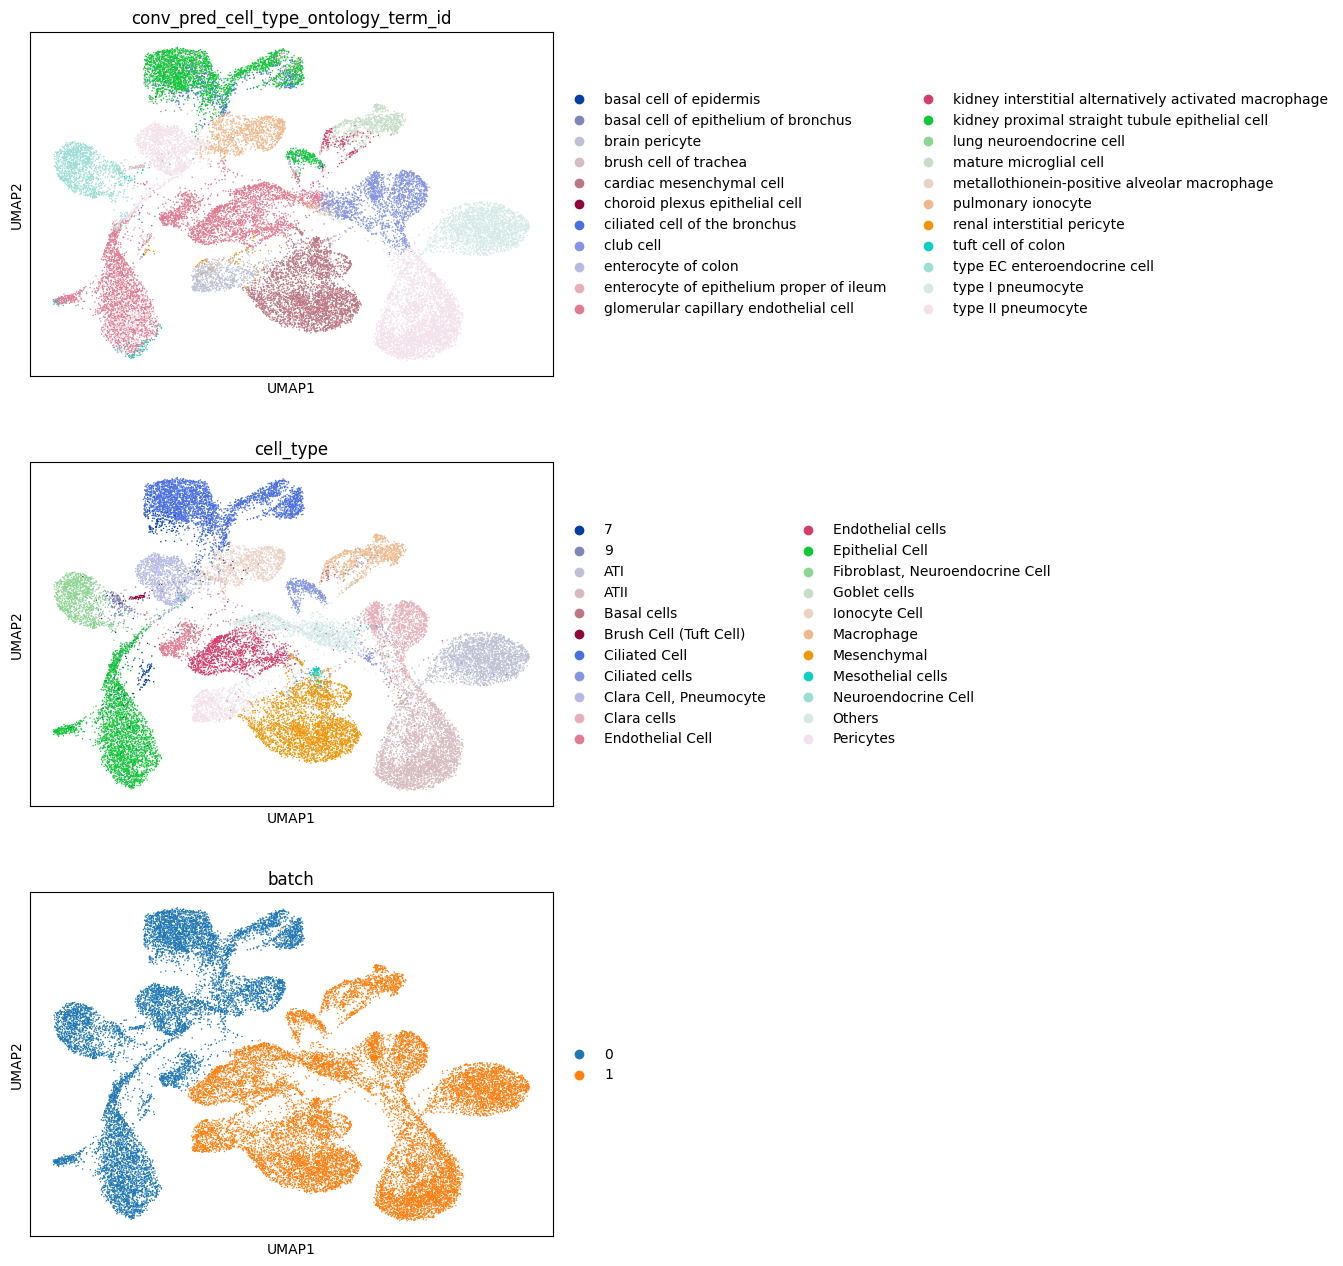

In [20]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb_cell_type_ontology_term_id")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

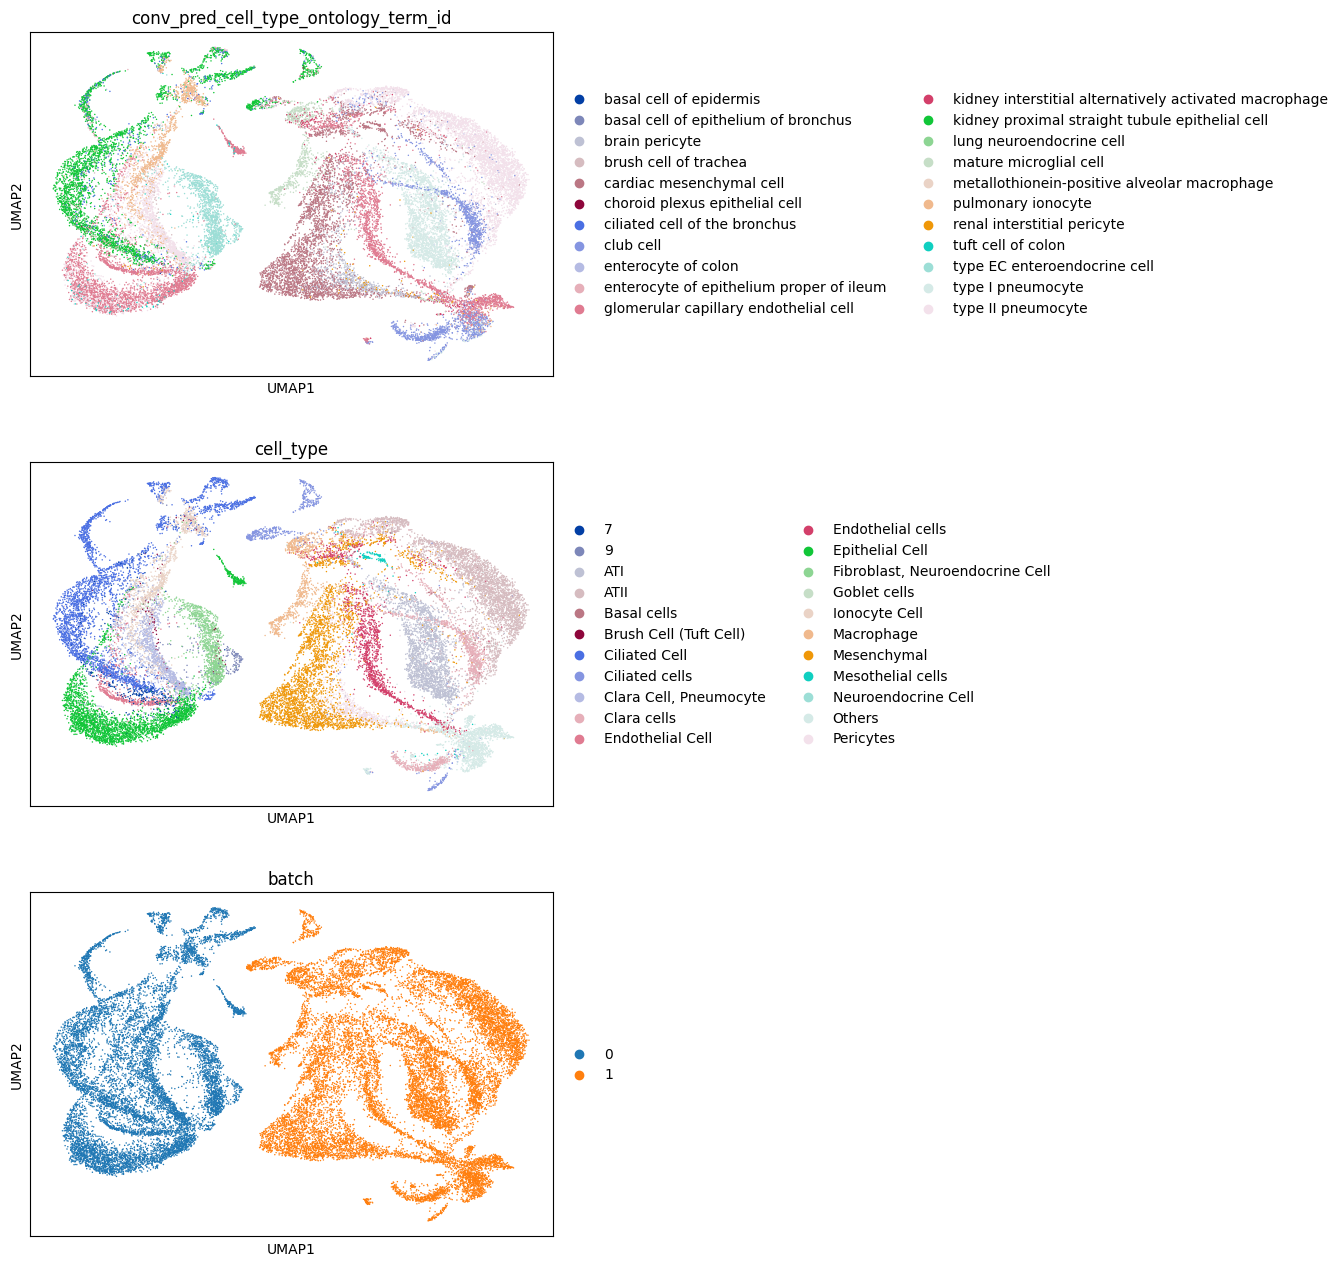

In [21]:
sc.pp.neighbors(n_adata, use_rep="scprint_emb")
sc.tl.umap(n_adata)
sc.pl.umap(
    n_adata,
    color=["conv_pred_cell_type_ontology_term_id", "cell_type", "batch"],
    ncols=1,
)

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [ ]:
bm = Benchmarker(
    n_adata,
    batch_key="batch",  # batch, tech, assay_ontology_term_id, donor_id
    label_key="cell_type_ontology_term_id",  # celltype
    embedding_obsm_keys=["scprint_emb_cell_type_ontology_term_id"],
    bio_conservation_metrics=BioConservation(),
    batch_correction_metrics=BatchCorrection(),
    n_jobs=10,
)
bm.benchmark()

/pasteur/appa/homes/jkalfon/scPRINT/.venv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(



Computing neighbors:   0%|          | 0/1 [00:00<?, ?it/s]


Computing neighbors:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: The number of threads must be between 1 and 11

In [ ]:
# after fine tuning
bm.plot_results_table(min_max_scale=False)